# Context

Slow waves events cosist of several segments. We aim at splitting them automatically.

# Imports

In [1]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [2]:
import imageio
from pathlib import Path
from matplotlib.pyplot import show
from argparse import ArgumentParser

from pyoptflow.plots import compareGraphs

In [3]:
from PIL import Image
import os
from scipy.signal import argrelextrema
from skimage import exposure

In [4]:
import matplotlib
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

### Import our custom utility methods

In [5]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('../..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

The following modules are available

In [6]:
print_module_methods(utils.diverse)

print_module_methods(module)



In [7]:
print_module_methods(utils.visualization_tools)

HTML(data=None, url=None, filename=None, metadata=None)

display_combined(u, v, Inew, scale=100, quivstep=3, fig=None, ax=None, figsize=(10, 10), vmin=0, vmax=1, head_width=1)

plot_vector_as_field(y, x, scale=1)

print_points_and_background(img, x, y, point_size=10, marker='.')

show_video(frames, frames1=None, n_frames=20, startframe=0, orient='horizontal', figsize=(10, 10), vmin=0, vmax=1, cmap='viridis', show_framenumber=True)

superimpose(img, background, cm_background=<matplotlib.colors.LinearSegmentedColormap object at 0x7f550c72f850>, cm_foreground=<matplotlib.colors.ListedColormap object at 0x7f550c7a6ad0>)

vector_field_animation(y_comp, x_comp, tensor, start=0, frames=40, quivstep=5, scale=100)



In [8]:
print_module_methods(utils.data_transformations)

HornSchunck(im1: numpy.ndarray, im2: numpy.ndarray, alpha: float = 0.001, Niter: int = 8, verbose: bool = False) -> Tuple[numpy.ndarray, numpy.ndarray]

PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

apply_mask(frames, mask, nan=False)

argrelextrema(data, comparator, axis=0, order=1, mode='clip')

binary_dilation(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

binary_erosion(input, structure=None, iterations=1, mask=None, output=None, border_value=0, origin=0, brute_force=False)

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)

butter_bandstop_filter(data, lowcut, highcut, fs, order)

center_of_mass(a)

clipped_adaptive(tensor, clipping=0.8)

discard_minor_components(tensor, keep_components=3, n_components=None, pca=None, fit_only=False)

equalize_adapthist(image, kernel_size=None, clip_limit=0.01, nbins=256)

expected_flow(tensor, n_fram

In [9]:
preprocessed_data_dir = "../../datasets/contrast_to_pixelwise_mean/"
os.listdir(preprocessed_data_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/contrast_to_pixelwise_mean/'

In [10]:
vector = np.load(os.path.join(preprocessed_data_dir,"runstart16_X1_mean.npy"))

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/contrast_to_pixelwise_mean/runstart16_X1_mean.npy'

In [11]:
def where_slow_wave(vector, percentile = 10, smoothing = 2, erosion = 10):
    down_state = np.zeros(len(vector))
    down_state[vector<np.percentile(vector, percentile)] = 1
    down_state = gaussian_filter(down_state, smoothing)>0
    up_state = ~binary_erosion(down_state, iterations=erosion)
    return up_state

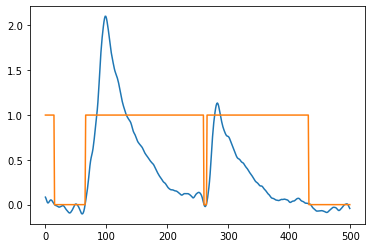

In [12]:
plt.plot(vector[:500])
plt.plot(where_slow_wave(vector, 15,2,8)[:500])

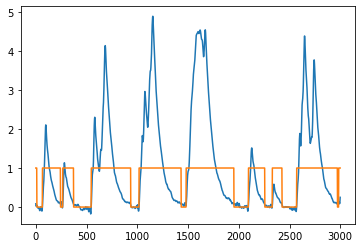

In [13]:
plt.plot(vector)
plt.plot(where_slow_wave(vector,25, 2, 10))

In [14]:
def get_slow_wave_start_stop(vector, percentile = 25, smoothing = 2, erosion= 10):
    where = where_slow_wave(vector, percentile, smoothing, erosion)
    crossings = list(zero_crossings(where-0.5))
    if where[0]:
        del crossings[0]#beginning already up state
    if where[-1]:
        del crossings[-1]#end up state
    return np.array_split(crossings, len(crossings)//2)

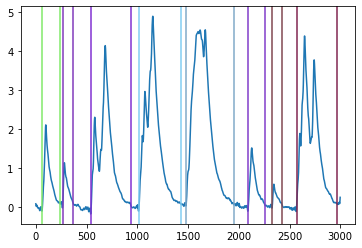

In [15]:
fig, ax = plt.subplots(1)
plt.plot(vector)
for start, stop in get_slow_wave_start_stop(vector):
    color = np.random.rand(3,)
    color[0] = .5
    ax.axvline(start, c=color)
    ax.axvline(stop, c=color)

In [16]:
starts_stops = np.array(get_slow_wave_start_stop(vector))

In [17]:
sws = []
for start_stop in starts_stops:
    sws.append(vector[start_stop[0]:start_stop[1]])

In [90]:
def split_rising_phase(section, smoothing = 1, delay = 0, debug=False):
    derivative = np.gradient(section)
    
    indices = list(minima(derivative, smoothing)+delay)
    indices.append(0)
    indices.append(len(section))
    indices.sort()
    indices = [[i,j] for i,j in zip(indices[:-1], indices[1:])]
    
    if debug:
        plt.plot(section)
        plt.plot(derivative*10)
        print(minima(derivative, smoothing))
        plt.show()
    
    sections = []
    for start, stop in indices:
        sections.append(section[start:stop])
        
    return indices, sections

def subsection_indices(slow_wave, smoothing1 = 7, smoothing2 = 2, delay = 0, debug = False):
    section_indices = []
    section_types = []

    minmax = list(maxima(slow_wave, smoothing1))
    minmax.extend(list(minima(slow_wave,smoothing1)))
    minmax.append(0)
    minmax.append(len(slow_wave))
    minmax.sort()
    
    if debug:
        fig, ax = plt.subplots(1, dpi=300)
        
    latest_rising_idx = 0
    latest_falling_idx = 0
    
    for start, stop in zip(minmax[:-1], minmax[1:]):
        section = slow_wave[start:stop]
        
        section_type = ""
        if section[-1] > section[0]:
            section_type = "rising"
        else:
            section_type = "falling"
            
        if section_type == "rising":
            subsection_indices, subsections = split_rising_phase(section, smoothing2, delay)
            subsection_indices = np.array(subsection_indices) + start
            if debug:
                for [start, stop], sub in zip(subsection_indices, subsections):
                    ax.plot(np.arange(stop-start)+start, sub)
            section_indices.extend(subsection_indices)
            
            for i in range(len(subsection_indices)):
                latest_rising_idx += 1
                section_types.append("rising_"+str(latest_rising_idx))
        else:
            section_indices.append([start,stop])
            latest_falling_idx += 1
            section_types.append("falling_"+str(latest_falling_idx))
            if debug:
                ax.plot(np.arange(stop-start)+start,section)
    if debug:
        ax.set_ylabel('df/t')
        ax.set_xlabel("time [ms]")
        plt.show()
    return np.array(section_indices), section_types

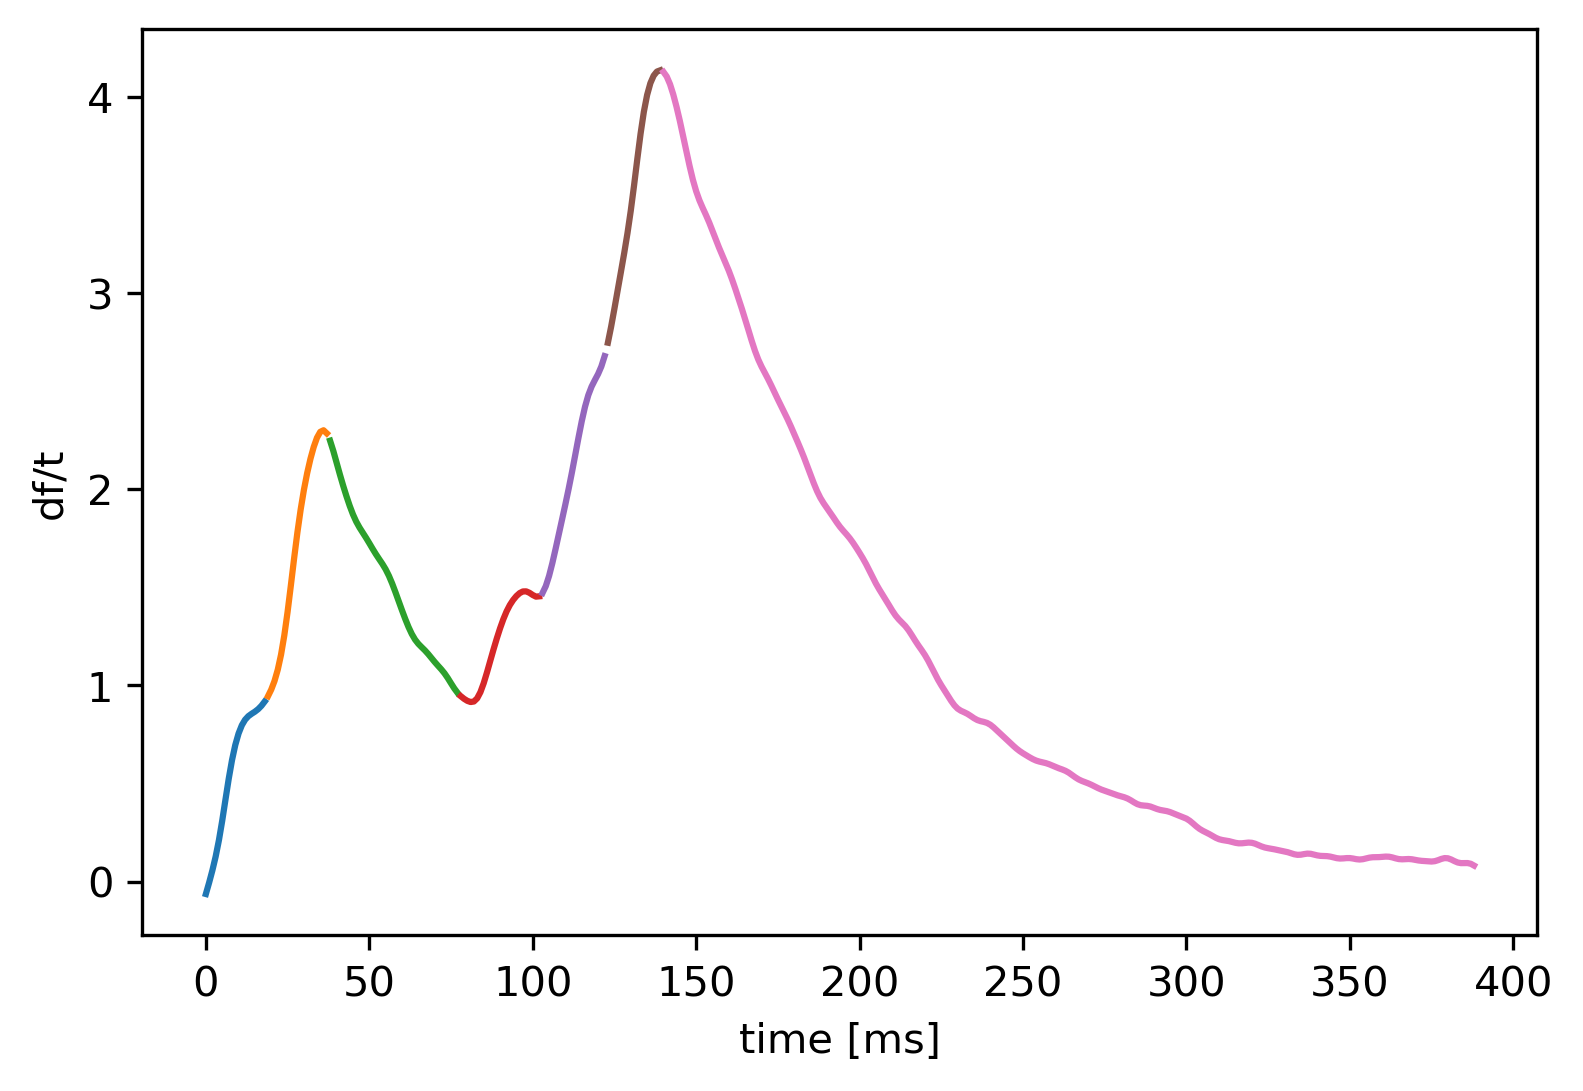

(array([[  0,  19],
        [ 19,  38],
        [ 38,  78],
        [ 78, 103],
        [103, 123],
        [123, 140],
        [140, 389]]),
 ['rising_1',
  'rising_2',
  'falling_1',
  'rising_3',
  'rising_4',
  'rising_5',
  'falling_2'])

In [91]:
subsection_indices(sws[2],smoothing2=3, delay=4, debug = True)

In [185]:
def get_slow_wave_segments(vector, min_duration = None):
    starts_stops = np.array(get_slow_wave_start_stop(vector))
    sws = []
    for start_stop in starts_stops:
        sws.append(vector[start_stop[0]:start_stop[1]])
    indices = []
    names = []
    for sw, [start, stop] in zip(sws, starts_stops):
        idxs, nms = subsection_indices(sw,smoothing1=7,delay=5)
        idxs += start
        indices.extend(list(idxs))
        names.extend(list(nms))
    
    if min_duration:
        for i, [start, stop] in enumerate(indices):
            if stop-start < min_duration:
                if i+1 < len(indices):
                    if indices[i+1][0] < start + min_duration:
                        indices[i+1][0] = start + min_duration
                indices[i][1] = start + min_duration
    return starts_stops, indices, names

In [190]:
starts_stops, indices, names = get_slow_wave_segments(vector, 10)

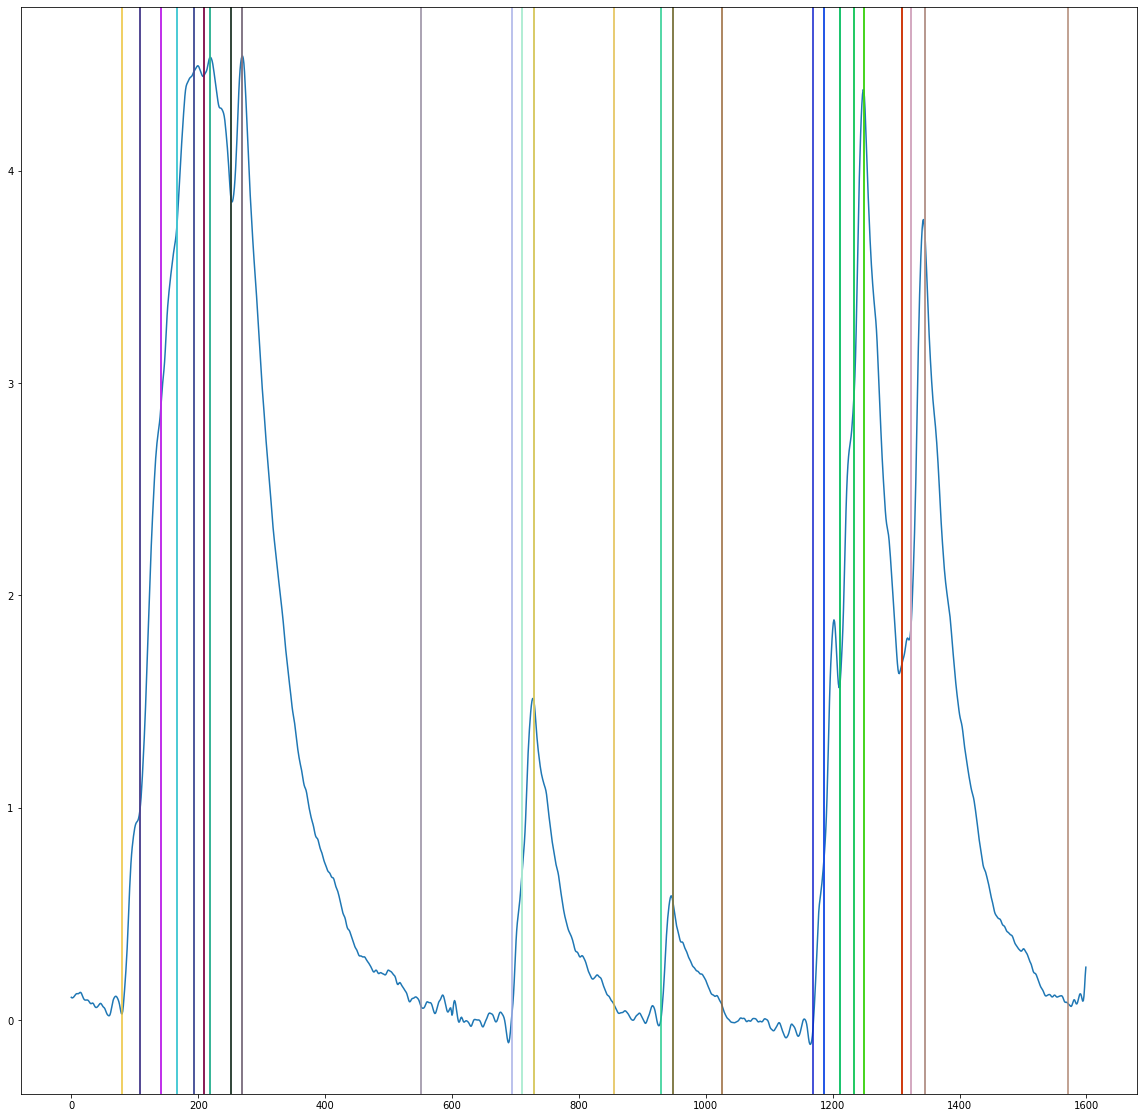

In [191]:
fig, ax = plt.subplots(1, figsize= (20,20))
ax.plot(vector[1400:4000])
for start, stop in indices:
    if start < 1400 or start > 4000:
        continue
    color = np.random.rand(3,)

    ax.axvline(start-1400, c=color)
    ax.axvline(stop-1400, c=color)